In [2]:
import os.path
import pickle
import random

from wbtools.lib.nlp.text_preprocessing import get_documents_from_text
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt
import numpy as np
import random
import umap
from scipy import spatial

import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

## Define constants

In [4]:
min_sentence_length = 20
max_corpus_size = 100000
use_cached_embeddings = True
bio_sent_vec_model_location = "../biosentvec/model.bin"

## Read positive and negative sentences from file

In [7]:
def read_positive_sentences_from_file(filepath, min_sent_length=20):
    return [sentence for line in open(filepath) for sentence in get_documents_from_text(
        text=line.strip(), split_sentences=True) if len(sentence) > min_sent_length]

sent_expr_pattern = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_pattern.txt",
                                                      min_sentence_length)
sent_subcellloc = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_subcellloc.txt",
                                                    min_sentence_length)
neg_sent_otherxpr = [sent for sent in open("../extracted_sentences/neg_sentences_otherexpr.txt") if len(sent) >
                     min_sentence_length]

## Clean sentences

In [8]:
def clean_sentences(sentences):
    stop_words = set(stopwords.words('english'))
    ret_sent = []
    for sentence in sentences:
        sentence = sentence.replace('/', ' / ')
        sentence = sentence.replace('.-', ' .- ')
        sentence = sentence.replace('.', ' . ')
        sentence = sentence.replace('\'', ' \' ')
        tokens = [token for token in word_tokenize(sentence) if token not in punctuation and token not in stop_words]
        sentence = ' '.join(tokens)
        ret_sent.append(sentence)
    return list(set([sent.strip(' ').strip('.;,/-|').strip() for sent in ret_sent]))

sent_expr_pattern_clean = clean_sentences(sent_expr_pattern)
sent_subcellloc_clean = clean_sentences(sent_subcellloc)
neg_sent_otherxpr_clean = clean_sentences(neg_sent_otherxpr)

## Sample sentences

In [9]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_expr_pattern.txt") and os.path.exists("../sentence_embeddings/corpus_subcellloc.txt") and os.path.exists("../sentence_embeddings/corpus_neg_otherexpr.txt"):
    corpus_expr_pattern = [line.strip() for line in open("../sentence_embeddings/corpus_expr_pattern.txt")]
    corpus_expr_subcellloc = [line.strip() for line in open("../sentence_embeddings/corpus_subcellloc.txt")]
    corpus_neg_otherexpr = [line.strip() for line in open("../sentence_embeddings/corpus_neg_otherexpr.txt")]
else:
    corpus_expr_pattern = get_random_sentence_subset(sent_expr_pattern_clean, max_corpus_size)
    corpus_expr_subcellloc = get_random_sentence_subset(sent_subcellloc_clean, max_corpus_size)
    corpus_neg_otherexpr = get_random_sentence_subset(neg_sent_otherxpr_clean, max_corpus_size)
    with open("../sentence_embeddings/corpus_expr_pattern.txt", "w") as corpus_expr_pattern_file:
        for sent in corpus_expr_pattern:
            corpus_expr_pattern_file.write(sent + "\n")
    with open("../sentence_embeddings/corpus_subcellloc.txt", "w") as corpus_expr_subcellloc_file:
        for sent in corpus_expr_subcellloc:
            corpus_expr_subcellloc_file.write("sent" + "\n")
    with open("../sentence_embeddings/corpus_neg_otherexpr.txt", "w") as corpus_neg_otherexpr_file:
        for sent in corpus_neg_otherexpr:
            corpus_neg_otherexpr_file.write("sent" + "\n")

## Extract sentence embeddings with SBERT

In [16]:
if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_subcellloc.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle"):
    corpus_embeddings_expr_pattern = pickle.load(open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "rb"))
    corpus_embeddings_subcellloc = pickle.load(open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "rb"))
    corpus_embeddings_neg_otherexpr = pickle.load(open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "rb"))
else:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    corpus_embeddings_expr_pattern = embedder.encode(corpus_expr_pattern, convert_to_tensor=True)
    corpus_embeddings_subcellloc = embedder.encode(corpus_expr_subcellloc, convert_to_tensor=True)
    corpus_embeddings_neg_otherexpr = embedder.encode(corpus_neg_otherexpr, convert_to_tensor=True)
    pickle.dump(corpus_embeddings_expr_pattern, open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "wb"))
    pickle.dump(corpus_embeddings_subcellloc, open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "wb"))
    pickle.dump(corpus_embeddings_neg_otherexpr, open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "wb"))

## Use UMAP to obtain a dataset that can be visualized in 2d

In [17]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern)
corpus_embeddings_subcellloc_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc)
corpus_embeddings_neg_otherexpr_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr)

In [18]:
colors = ['g'] * len(corpus_embeddings_expr_pattern_2d) + ['y'] * len(corpus_embeddings_subcellloc_2d) + ['b'] * len(corpus_embeddings_neg_otherexpr_2d)

In [189]:
all_corpora_2d = np.vstack((corpus_embeddings_expr_pattern_2d, corpus_embeddings_subcellloc_2d, corpus_embeddings_neg_otherexpr_2d))

## UMAP visualization with different colors for each sentence category
expr_pattern = green
subcellloc = yellow
negative = blue

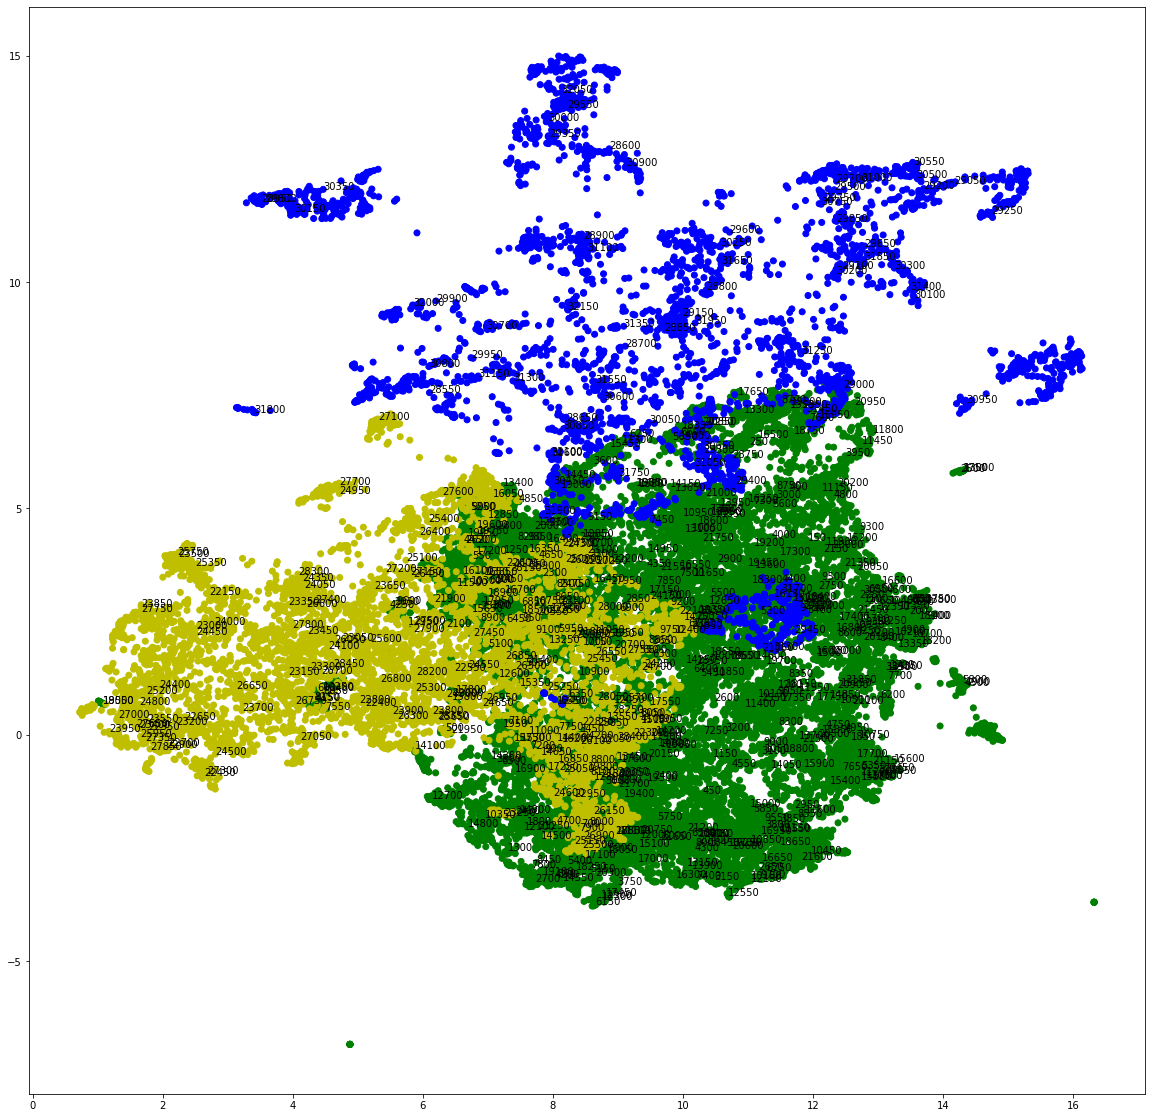

In [190]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_2d[:,0]), y=list(all_corpora_2d[:,1]), c=colors)
for i in range(len(all_corpora_2d)):
    if i % 50 == 0:
        plt.annotate(str(i), (all_corpora_2d[i,0], all_corpora_2d[i,1]))

In [191]:
best_matches = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr, corpus_embeddings=corpus_embeddings_expr_pattern)

In [192]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8]

[(394, {'corpus_id': 2208, 'score': 0.8020633459091187}),
 (1698, {'corpus_id': 21816, 'score': 0.8034310340881348}),
 (2474, {'corpus_id': 10403, 'score': 0.916601300239563})]

In [193]:
1 - spatial.distance.cosine(corpus_embeddings_neg_otherexpr[394], corpus_embeddings_expr_pattern[2208])

0.8020632266998291

# Extract sentence embeddings with BioSentVec

In [5]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [10]:
corpus_embeddings_expr_pattern_bio = biosentvec_model.embed_sentences(corpus_expr_pattern)
corpus_embeddings_subcellloc_bio = biosentvec_model.embed_sentences(corpus_expr_subcellloc)
corpus_embeddings_neg_otherexpr_bio = biosentvec_model.embed_sentences(corpus_neg_otherexpr)

In [11]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_bio_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern_bio)
corpus_embeddings_subcellloc_bio_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc_bio)
corpus_embeddings_neg_otherexpr_bio_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr_bio)

In [12]:
all_corpora_bio_2d = np.vstack((corpus_embeddings_expr_pattern_bio_2d, corpus_embeddings_subcellloc_bio_2d, corpus_embeddings_neg_otherexpr_bio_2d))

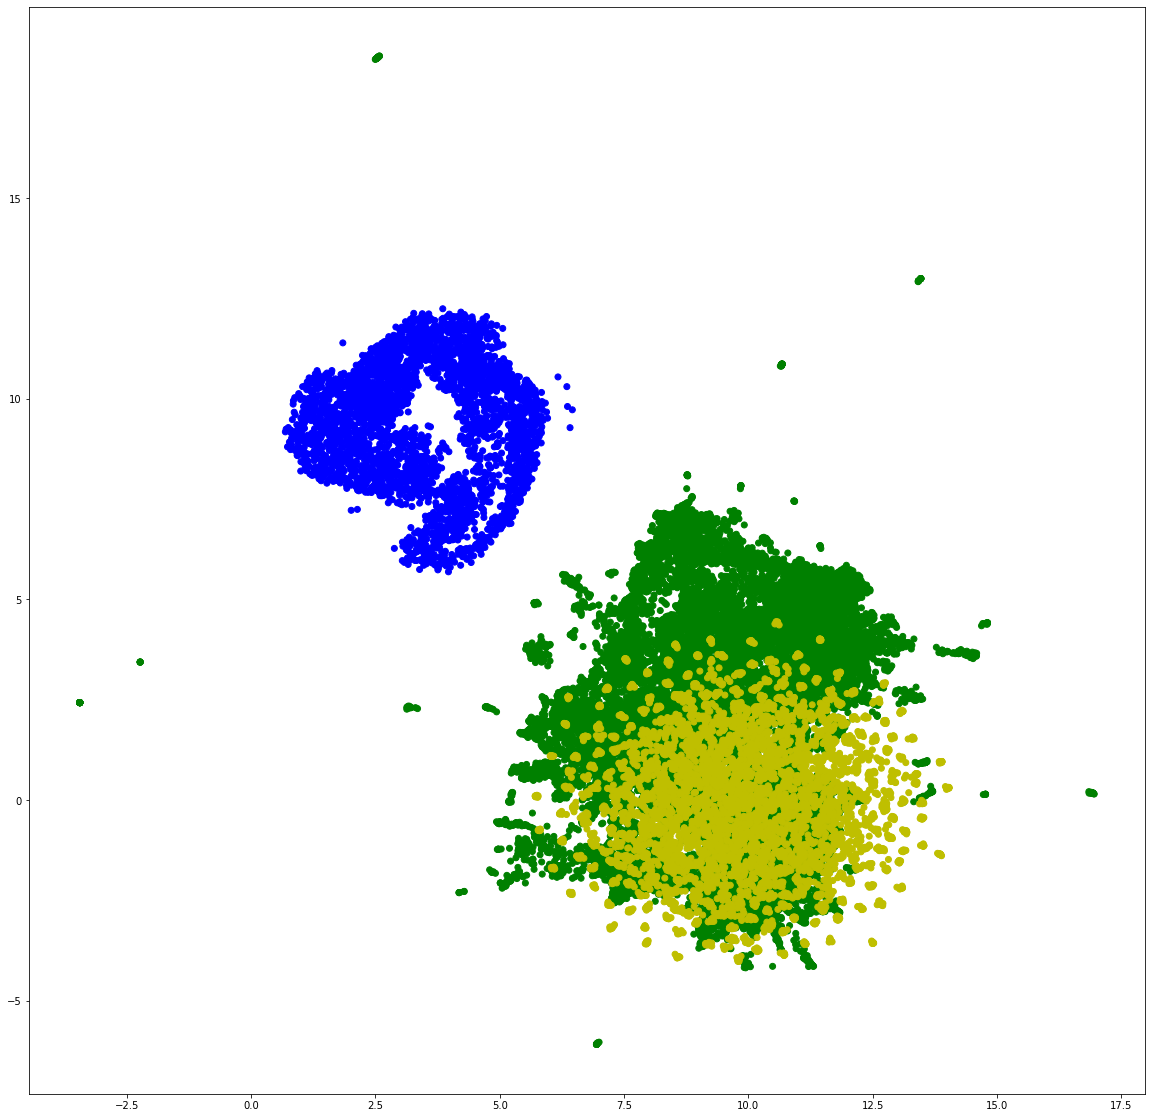

In [19]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_bio_2d[:,0]), y=list(all_corpora_bio_2d[:,1]), c=colors)

In [25]:
best_matches_bio = util.semantic_search(query_embeddings=corpus_embeddings_expr_pattern_bio, corpus_embeddings=corpus_embeddings_expr_pattern_bio)

In [30]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches_bio) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.97 and corpus_id_score_dict['corpus_id'] != i]

[(7, {'corpus_id': 21164, 'score': 0.989556074142456}),
 (7, {'corpus_id': 7653, 'score': 0.9860247373580933}),
 (7, {'corpus_id': 15148, 'score': 0.9792366623878479}),
 (7, {'corpus_id': 13570, 'score': 0.9779285192489624}),
 (7, {'corpus_id': 5496, 'score': 0.9753041863441467}),
 (7, {'corpus_id': 7360, 'score': 0.9703842401504517}),
 (8, {'corpus_id': 20278, 'score': 0.9713739156723022}),
 (8, {'corpus_id': 19915, 'score': 0.9700682163238525}),
 (32, {'corpus_id': 12581, 'score': 0.9846316576004028}),
 (37, {'corpus_id': 17349, 'score': 0.9920310974121094}),
 (37, {'corpus_id': 6142, 'score': 0.9819647669792175}),
 (37, {'corpus_id': 9626, 'score': 0.9728854894638062}),
 (37, {'corpus_id': 20365, 'score': 0.9709606170654297}),
 (37, {'corpus_id': 16447, 'score': 0.9705426096916199}),
 (52, {'corpus_id': 3301, 'score': 0.9821870923042297}),
 (55, {'corpus_id': 4771, 'score': 0.998328685760498}),
 (62, {'corpus_id': 18802, 'score': 0.9858793020248413}),
 (62, {'corpus_id': 12450, 'sco

In [36]:
corpus_expr_pattern[8]

'Adult Expression pharynx intestine anal depressor muscle Reproductive System spermatheca body wall muscle excretory gland cells Nervous System head neurons tail neurons |Larval Expression pharynx intestine anal depressor muscle Reproductive System developing vulva developing uterus body wall muscle excretory gland cells Nervous System head neurons tail neurons'

In [35]:
corpus_expr_pattern[20278]

'Larval Expression pharynx intestine rectal gland cells anal depressor muscle Reproductive System distal tip cell developing vulva developing uterus body wall muscle Nervous System head neurons amphids tail neurons phasmids |Adult Expression pharynx intestine rectal gland cells anal depressor muscle Reproductive System vulval muscle spermatheca body wall muscle hypodermis excretory cell Nervous System head neurons tail neurons'